## Problem Statement



# Spam SMS Classification using LSTM

The SMS spam is a growing problem considering availability of cheap sms packages offered by various telecom service companies. SMS spam filtering is a relatively new task which inherits many issues and solutions from email spam filtering. The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged according to ham (legitimate) or spam.



### Objective:
Given a text message and label whether a sms is a spam message, can you train a model using LSTM that allows you to correctly predict a new sms as spam or ham.

## 1. Import Libraries

Let us start by mounting the drive

from google.colab import drive
drive.mount('/content/drive')

Let us check for the version of installed tensorflow.

In [1]:
# used to supress display of warnings
import warnings

# os is used to provide a way of using operating system dependent functionality
# We use it for setting working folder
import os

# Pandas is used for data manipulation and analysis
import pandas as pd 

# Numpy is used for large, multi-dimensional arrays and matrices, along with mathematical operators on these arrays
import numpy as np

# Matplotlib is a data visualization library for 2D plots of arrays, built on NumPy arrays 
# and designed to work with the broader SciPy stack
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot

# Seaborn is based on matplotlib, which aids in drawing attractive and informative statistical graphics.
import seaborn as sns
import tensorflow 
print(tensorflow.__version__)

2.3.0


## 2. Setting Options

In [2]:
# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

## 3. Read Data

In [3]:
import os
#os.chdir('/content/drive/My Drive/Samsung Internal SSD Reviews/')
os.chdir('./')

In [4]:
import chardet
with open('spam.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1252', 'confidence': 0.7270322499829184, 'language': ''}

In [5]:
dataframe = pd.read_csv('spam.csv', encoding='Windows-1252')

In [6]:
dataframe.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
dataframe.shape

(5572, 5)

## 4.  Data Analysis and Preparation

Create a new dataframe with relevant column only

In [8]:
data = dataframe[["v1","v2"]]

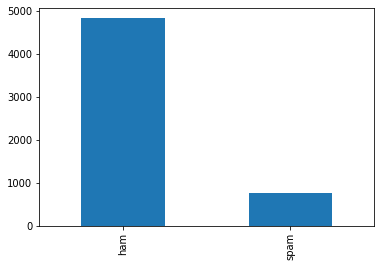

In [9]:
data['v1'].value_counts().plot(kind = 'bar');

Given data is highly unbalanced.

In [10]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
data.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Drop NaN values if any

In [12]:
data.shape

(5572, 2)

In [17]:
print(data['v1'].value_counts())

ham     4516
spam     653
Name: v1, dtype: int64


In [13]:
data.isnull().values.any()

False

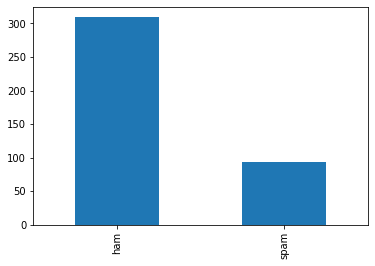

In [14]:
data[data.duplicated()]['v1'].value_counts().plot(kind = 'bar') 

we can remove dublicate entries

In [15]:
data.drop_duplicates(inplace=True)

In [16]:
data.shape

(5169, 2)

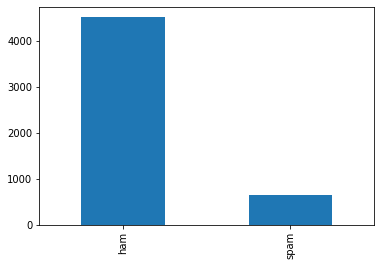

In [18]:
data['v1'].value_counts().plot(kind = 'bar') 

In [19]:
print(data['v1'].value_counts())

ham     4516
spam     653
Name: v1, dtype: int64


calculate the length of each review

In [20]:
data['len'] = data['v2'].apply(lambda x:len(x.split(" ")))

In [21]:
data.head()

,v1,v2,len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


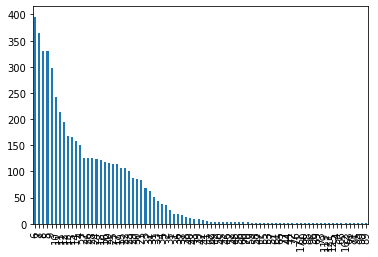

In [22]:
data['len'].value_counts().plot(kind = 'bar') 

In [28]:
print("maximum SMS length = "+str(data.len.max()) )
print("Median SMS length = "+str(data.len.median()) )
print("Mean length = "+str(data.len.mean()) )

maximum SMS length = 171
Median SMS length = 12.0
Mean length = 15.455987618494873


In [27]:
data.len.describe()

count   5169.0000000
mean      15.4559876
std       11.1638535
min        1.0000000
25%        7.0000000
50%       12.0000000
75%       22.0000000
max      171.0000000
Name: len, dtype: float64

We are setting max length of each sms to 25 since it results in faster training.
We will experiment with different values later on

In [29]:
max_features = 10000
maxlen = 25
embedding_size = 50

Let us tokenize the text

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(data['v2']))
X = tokenizer.texts_to_sequences(data['v2'])

print("Number of Samples:", len(X))       
print(X[0]) 

Number of Samples: 5169
[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137]


In [33]:
len(data['v2'][0])

111

Let us pad all the reviews

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

X = pad_sequences(X, maxlen = maxlen)     


Output Class label

In [35]:
y = np.asarray(data['v1'])

print("Number of Labels: ", len(y))     
print(y[0])

Number of Labels:  5169
ham


In [36]:
tokenizer.word_index

{'i': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'the': 5,
 'u': 6,
 'and': 7,
 'in': 8,
 'is': 9,
 'me': 10,
 'my': 11,
 'for': 12,
 'your': 13,
 'it': 14,
 'of': 15,
 'have': 16,
 'call': 17,
 'that': 18,
 'on': 19,
 '2': 20,
 'are': 21,
 'now': 22,
 'so': 23,
 'but': 24,
 'not': 25,
 'can': 26,
 'at': 27,
 'or': 28,
 "i'm": 29,
 'do': 30,
 'be': 31,
 'get': 32,
 'will': 33,
 'just': 34,
 'if': 35,
 'with': 36,
 'we': 37,
 'no': 38,
 'this': 39,
 'ur': 40,
 'up': 41,
 'gt': 42,
 'lt': 43,
 '4': 44,
 'how': 45,
 'when': 46,
 'go': 47,
 'from': 48,
 'ok': 49,
 'out': 50,
 'all': 51,
 'what': 52,
 'free': 53,
 'know': 54,
 'like': 55,
 'then': 56,
 'got': 57,
 'good': 58,
 'come': 59,
 'am': 60,
 'was': 61,
 'time': 62,
 'its': 63,
 'only': 64,
 'day': 65,
 'want': 66,
 'love': 67,
 'there': 68,
 'he': 69,
 'text': 70,
 'send': 71,
 'going': 72,
 'one': 73,
 'need': 74,
 'by': 75,
 'lor': 76,
 'home': 77,
 'as': 78,
 'about': 79,
 'still': 80,
 'see': 81,
 'txt': 82,
 'back': 83,
 'r': 84,
 'sto

Let us see the total number of words in the dictionary

In [37]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

8921


Let us compute the glove embeddings

In [40]:
#EMBEDDING_FILE = '/content/drive/My Drive/glove.6B.50d.txt'
EMBEDDING_FILE = '/home/gopalag/Project/NLP/Week2-WordEmbedding/glove.6B.50d.txt'
embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 50))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [41]:
len(embeddings.values())

400000

In [53]:
embedding_matrix.shape

(8921, 50)

In [42]:
num_words

8921

Let us one hot encode the target variables

In [43]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(y.reshape(-1,1))

Convert sparse scipy matrix to nd array

In [44]:
y = y.todense()

In [55]:
y[0]

matrix([[1., 0.]])

Train Test Split

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 50, stratify=y, test_size=0.3)

In [58]:
print(X_train.shape)
print(X_test.shape)

(3618, 25)
(1551, 25)


In [60]:
print(y_train.shape)
print(y_test.shape)

(3618, 2)
(1551, 2)


## 6. Model building

Let us construct a neural network architecture for building our rating predictions model

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten
from functools import partial

model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix], input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

In [62]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 50)            446050    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 256)           183296    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               3277312   
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [64]:
batch_size = 100
epochs = 20

training_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/20
37/37 [==============================] - 3s 84ms/step - loss: 0.1980 - accuracy: 0.9370 - val_loss: 0.0916 - val_accuracy: 0.9729
Epoch 2/20
37/37 [==============================] - 3s 73ms/step - loss: 0.0719 - accuracy: 0.9798 - val_loss: 0.0791 - val_accuracy: 0.9768
Epoch 3/20
37/37 [==============================] - 3s 72ms/step - loss: 0.0457 - accuracy: 0.9889 - val_loss: 0.1026 - val_accuracy: 0.9761
Epoch 4/20
37/37 [==============================] - 3s 83ms/step - loss: 0.0296 - accuracy: 0.9920 - val_loss: 0.0947 - val_accuracy: 0.9774
Epoch 5/20
37/37 [==============================] - 3s 74ms/step - loss: 0.0181 - accuracy: 0.9947 - val_loss: 0.1174 - val_accuracy: 0.9768
Epoch 6/20
37/37 [==============================] - 3s 75ms/step - loss: 0.0200 - accuracy: 0.9945 - val_loss: 0.0812 - val_accuracy: 0.9794
Epoch 7/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0126 - accuracy: 0.9953 - val_loss: 0.1378 - val_accuracy: 0.9742
Epoch 8/20
37

In [65]:
predictions = model.predict(X_test.reshape(len(X_test),25))

In [66]:
y_test_inv = enc.inverse_transform(y_test)

In [67]:
y_pred_inv = enc.inverse_transform(np.around(predictions))

In [68]:
y_test_inv.shape

(1551, 1)

In [69]:
y_pred_inv.shape

(1551, 1)

In [70]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_inv, y_pred_inv)

array([[1332,   23],
       [  13,  183]])

In [71]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_inv, y_pred_inv)

0.97678916827853

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test_inv, y_pred_inv))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99      1355
        spam       0.89      0.93      0.91       196

    accuracy                           0.98      1551
   macro avg       0.94      0.96      0.95      1551
weighted avg       0.98      0.98      0.98      1551



Text(0.5, 1.0, 'Training and validation loss')

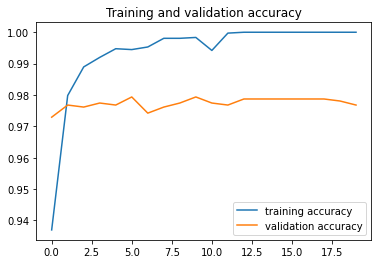

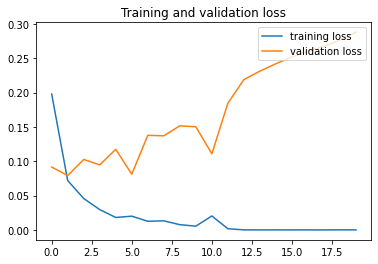

In [73]:
import matplotlib.pyplot as plt
accuracy      = training_history.history['accuracy']
val_accuracy  = training_history.history['val_accuracy']
loss     = training_history.history['loss']
val_loss = training_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  ( epochs, accuracy, label = 'training accuracy' )
plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss' )
plt.plot  ( epochs, val_loss, label = 'validation loss' )
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss'   )

### 6. Conclusion and Interpretation

1.) We get an overall accuracy of 78% in our model however, this is completely biased towards one class.

2.) Our mean precision value weighted average is 75%. However, class wise precision is still poor which resulted in a mean precision value of 43%, this is attributed to the highly imbalanced dataset.

Food for thought:

1.) Change activation function (try leaky_relu or tanh) and see if it helps in improving model performance with the dataset that is highly imbalanced

2.) Try with only the overall review feature and see if it leads to improvement in model performace

3.) Change the hyperparameters of the model and compare the results 